![dory_meme](dory-meme.png)

# Lab 9: RNNs and LSTMs

Proteins are biological molecules made of chains of amino acids. They do pretty much everying in the body. Different amino acids have different physical characteristics, so their combinations can be viewed as combinations of words in a sentence, depending on their function. In bioinformatics, we represent proteins as strings of characters. With the mighthy power of recurrent neural networks, we can desipher the protein code!

The goal of this lab is to differentiate between trans-membrane proteins and proteins in non-membrane bound organelled (These are both GO identifiers)

![membrane_protein](https://upload.wikimedia.org/wikipedia/commons/d/db/Polytopic_membrane_protein.png)

In [1]:
from Bio import SeqIO
from Bio import Alphabet
import numpy as np
import torch

In general, RNN's for text processing follow the following workflow: 
1. Load in and visualize data
2. Process data - create vocab, encode the words, and encode the labels. Remove outliers and weird looking text pieces
3. Split data into training, testing, and validation sets
4. Define a data loader to feed data into the network. 
5. Define the LSTM architecture and modelclas
6. Train the network, and test on user-generated data

Protein data is simpler than free text, so we can encode using one-hot encoding, where each amino acid is represented as a 20 dimensional vector of zeros, with a one in the position represnting the particular type of amino acid. 

First things first, we're gonna have to load the protein sequence data and process it in a way the network can understand. We'll do this through one-hot encoding. 

In [2]:
nmb_sequences = [x.seq for x in SeqIO.parse("protein_data/nmb_organelles_filter.fasta", "fasta")]
membrane_sequences = [x.seq for x in SeqIO.parse("protein_data/transmembrane.filter.fasta", "fasta")]

In [3]:
import matplotlib.pyplot as plt

(array([2.731e+03, 1.480e+02, 4.800e+01, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([   8. ,  514.2, 1020.4, 1526.6, 2032.8, 2539. , 3045.2, 3551.4,
        4057.6, 4563.8, 5070. ]),
 <a list of 10 Patch objects>)

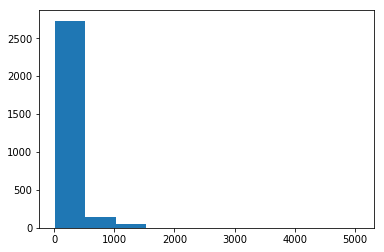

In [4]:
plt.hist([len(x) for x in nmb_sequences])

(array([1995.,  647.,  146.,   12.,    6.,    5.,    0.,    0.,    0.,
           4.]),
 array([4.0000e+00, 5.0730e+02, 1.0106e+03, 1.5139e+03, 2.0172e+03,
        2.5205e+03, 3.0238e+03, 3.5271e+03, 4.0304e+03, 4.5337e+03,
        5.0370e+03]),
 <a list of 10 Patch objects>)

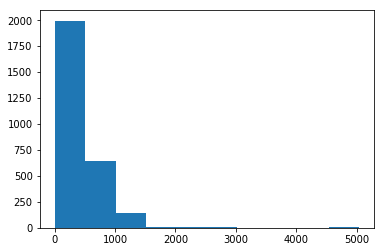

In [5]:
plt.hist([len(x) for x in membrane_sequences])

Let's filter out some of the sequences that are really long, since that will make our lives easier down that road. The maximum length chosen for the sequence will also be the number of time steps needed when defining your LSTM, so choose carefully :-)

In [18]:
time_steps = 2000

In [19]:
nmb_sequences = [seq for seq in nmb_sequences if len(seq) < time_steps]
membrane_sequences = [seq for seq in membrane_sequences if len(seq) < time_steps]

In [20]:
labels = ["organelle" for _ in range(len(nmb_sequences))] +\
["membrane"  for _ in range(len(membrane_sequences))]

In [10]:
sequences = nmb_sequences + membrane_sequences

In NLP, the next task is typically to create a vocabulary of all words used in the training data. For classifying proteins, this process is easy. (Hint, the vocabulary is defined in the next cell)

In [11]:
protein_alphabet = Alphabet.IUPAC.IUPACProtein.letters
n_aas = len(protein_alphabet)
print(protein_alphabet, n_aas)

ACDEFGHIKLMNPQRSTVWY 20


The next step is to encode the words. In our simple one hot encoding method, we need a way to map amino acids to an index, and then map a string of amino acids to a one-hot encoded tensor. 

In [12]:
def aaToIndex(aa):
    return protein_alphabet.find(aa)

# To feed a one hot encoded data into an RNN or LSTM, 
# every data point has to be the same dimension
def proteinToTensor(protein, train_length = 400):
    tensor = torch.zeros(train_length, 1, n_aas)
    for aa_i, aa in enumerate(protein):
        if aa_i < train_length:
            tensor[aa_i][0][aaToIndex(aa)] == 1
    return tensor

In [13]:
protein_int = []
for protein in sequences:
    p = [aaToIndex(aa) for i, aa in enumerate(protein)]
    protein_int.append(p)

Encode the labels. This can simply be a 0 or 1 for `membrane` and `organelle`. 

In [14]:
encoded_labels = [0 if label == 'organelle' else 1 for label in labels]

Shuffle the data. At this point, we can mix the data up so the labels aren't all zeros followed by all ones. Just make sure the apply the same ordering to the list of data as the list of labels!

In [15]:
len(encoded_labels)

5730

In [16]:
import random
shuffle_order = random.sample(range(len(encoded_labels)), len(encoded_labels))

protein_int = [protein_int[i] for i in shuffle_order]
encoded_labels = [encoded_labels[i] for i in shuffle_order]


### Pad the data
For all the sequences that didn't that aren't as long as the cutoff, add 0 to each element of the `protein_int` to get them up to the maximum length. 

In [21]:
protein_features = torch.zeros(len(protein_int), time_steps)
for i, seq in enumerate(protein_int):    
    seq_len = len(seq)
    zeros = list(torch.zeros(time_steps - seq_len))
    new = seq + zeros
    protein_features[i,:] = torch.tensor(new)
    

In [23]:
protein_features[0:10,:]

tensor([[13.,  2., 11.,  ...,  0.,  0.,  0.],
        [10.,  2.,  2.,  ...,  0.,  0.,  0.],
        [17.,  9., 15.,  ...,  0.,  0.,  0.],
        ...,
        [ 2., 12.,  8.,  ...,  0.,  0.,  0.],
        [ 5., 15.,  0.,  ...,  0.,  0.,  0.],
        [10.,  3., 17.,  ...,  0.,  0.,  0.]])

### Split the data into training and testing
Split the data and labels into 80% for training, 10% for validation, and 10% for testing

In [43]:
split_frac = 0.8
train_x = protein_features[0:int(split_frac*len(protein_int))]
train_y = encoded_labels[0:int(split_frac*len(protein_int))]

remaining_x = protein_features[int(split_frac*len(protein_int)):]
remaining_y = encoded_labels[int(split_frac*len(protein_int)):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = encoded_labels[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_x)*0.5):]

### Define data loaders
Again, these make loading data into your model a lot easier during training. 

In [45]:
from torch.utils.data import DataLoader, TensorDataset

# create 
train_data = TensorDataset(train_x, torch.IntTensor(train_y))
valid_data = TensorDataset(valid_x, torch.IntTensor(valid_y))
test_data = TensorDataset(test_x, torch.IntTensor(test_y))

# dataloaders 
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

### Define the model!!
Our "unrolled" model will look like this, as we slide along the protein sequence:
![LSTM_model](https://github.com/jeinson/jeinson.github.io/blob/master/images/LSTM%20Diagram.png?raw=true)

It wil take in the integer coded protein sequence, convert it to a one-hot encoded vector, and apply the LSTM transformation. 

In [56]:
aaToIndex('P')

12